## Script for plotting and analyzing results of subjective evaluation

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import config
import json
from pathlib import Path

plt.rcParams.update({'font.size': 18, 'axes.titlesize': 22, 'axes.labelsize': 20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'legend.fontsize': 16})

### Data loading

In [65]:
data_file = f'{config.EVAL_SUBJ_DIR}/experiment_results.json'

with open(data_file) as f:
    data = json.load(f)

In [66]:
df = pd.DataFrame({});

for id in data.keys():
    # print(f"ID: {id}")
    jsPsychData = data[id]['jspsych_data']
    length_jspsych_data = len(jsPsychData)
    # print(f"Length of jspsych_data: {len(jsPsychData)}")
    
    participant_data = {
        "id": data[id]['user_id'],
        "core_initial_visit": data[id]['core_initial_visit'],
        "early_termination": False,
        "termination_code": "COMPLETED",
        "failed_questions": None,
        "age": None,
        "gender": None,
        'country': None,
        'language': None,
        'tinnitus': None,
        'hearing_loss': None,
        'headphone_style': None,
        'trial_type': None,
        'factor': 0,
        'stimulus': None,
        'rating': None,
    };
    
    if (length_jspsych_data < 23): # did not finish the experiment
        last_trial = jsPsychData[-1]

        participant_data["early_termination"] = last_trial['early_termination']
        participant_data["termination_code"] = last_trial['reason']
        
        # find trial that is of trial_type "survey" and fetch "failed_questions"
        survey_trial = next((trial for trial in jsPsychData if trial.get('trial_type', '') == 'survey'), None)
        if survey_trial and 'failed_questions' in survey_trial:
            participant_data["failed_questions"] = survey_trial['failed_questions']
        
        df = pd.concat([df, pd.DataFrame([participant_data])], ignore_index=True);
        continue
    
            
    for trial in jsPsychData:
        if trial['trial_type'] == 'survey': # assumed to be before the experiment
            participant_data['age'] = trial['response']['age']
            participant_data['gender'] = trial['response']['gender']
            participant_data['country'] = trial['response']['country']
            participant_data['language'] = trial['response']['language']
            participant_data['tinnitus'] = trial['response']['tinnitus']
            participant_data['hearing_loss'] = trial['response']['hearing_loss']
            participant_data['headphone_style'] = trial['response']['headphone_style']
        
        if trial['trial_type'] == 'multiple-stimuli-hidden-reference-anchor' and trial['task_type'] in ['mushra_main_experiment']:
            is_tsm = 'tsm' in trial['type']
            if 'tsm' in trial['type']:
                participant_data['trial_type'] = 'tsm'
                participant_data['factor'] = float(trial['type'][3:]) 
            else:
                participant_data['trial_type'] = 'ps'
                participant_data['factor'] = float(trial['type'][2:])
                
            for response, stimulus in zip(trial['response'], trial['stimulus']):
                participant_data['stimulus'] = Path(stimulus).stem
                participant_data['rating'] = int(response)
                df = pd.concat([df, pd.DataFrame([participant_data])], ignore_index=True);
        
    

# sort data frame by early termination
df = df.sort_values(by=['early_termination'], ascending=False);


In [67]:
df

,id,core_initial_visit,early_termination,termination_code,failed_questions,age,gender,country,language,tinnitus,hearing_loss,headphone_style,trial_type,factor,stimulus,rating
542,pro|5dc937d48a84466671a2db68,2025-04-11 14:27:56.892204+00:00,True,HEADPHONE_FAIL,[],None,None,None,None,None,None,None,None,0.00,None,None
90,pro|6697ecff25ee5f53c257ca44,2025-04-11 13:22:35.912237+00:00,True,HEADPHONE_FAIL,[],None,None,None,None,None,None,None,None,0.00,None,None
543,pro|6728a33bf6aa750798eb8088,2025-04-11 13:19:40.301805+00:00,True,HEADPHONE_FAIL,[],None,None,None,None,None,None,None,None,0.00,None,None
361,pro|67e6adb1d37a753ccd430b01,2025-04-11 13:28:24.871518+00:00,True,PRESCREENING_FAIL,[hearing_loss],None,None,None,None,None,None,None,None,0.00,None,None
0,pro|60a59d92b7363e85a2945dde,2025-04-11 13:24:24.628187+00:00,False,COMPLETED,None,26,Woman (including Trans Female/Trans Woman),South Africa,[English],No,No,In-ear,ps,7.00,pvps,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,pro|66d749dad04d6166d7928a7f,2025-04-11 13:17:51.444310+00:00,False,COMPLETED,None,22,Man (including Trans Male/Trans Man),Hungary,"[Hungarian, English]",No,No,Over-the-ear,tsm,1.25,nm,20
306,pro|66d749dad04d6166d7928a7f,2025-04-11 13:17:51.444310+00:00,False,COMPLETED,None,22,Man (including Trans Male/Trans Man),Hungary,"[Hungarian, English]",No,No,Over-the-ear,tsm,1.50,pv,35
307,pro|66d749dad04d6166d7928a7f,2025-04-11 13:17:51.444310+00:00,False,COMPLETED,None,22,Man (including Trans Male/Trans Man),Hungary,"[Hungarian, English]",No,No,Over-the-ear,tsm,1.50,tsmnet,14
308,pro|66d749dad04d6166d7928a7f,2025-04-11 13:17:51.444310+00:00,False,COMPLETED,None,22,Man (including Trans Male/Trans Man),Hungary,"[Hungarian, English]",No,No,Over-the-ear,tsm,1.50,hps,25


In [68]:
df_completed = df[df['early_termination'] == False]
df_completed;

# df_completed = df_completed[df_completed['country'] == 'Denmark']
# df_completed = df_completed[df_completed['stimulus'] != 'ref']
# df_completed

Gender distribution:
gender
Man (including Trans Male/Trans Man)          13
Woman (including Trans Female/Trans Woman)     7
Name: count, dtype: int64

Countries:
['South Africa' 'Spain' 'United Kingdom' 'Portugal' 'Italy' 'Poland'
 'Greece' 'Mexico' 'France' 'Hungary']
Country distribution:
country
South Africa      8
Spain             2
United Kingdom    2
Portugal          2
Italy             1
Poland            1
Greece            1
Mexico            1
France            1
Hungary           1
Name: count, dtype: int64

Headphone styles:
headphone_style
In-ear          11
Over-the-ear     9
Name: count, dtype: int64


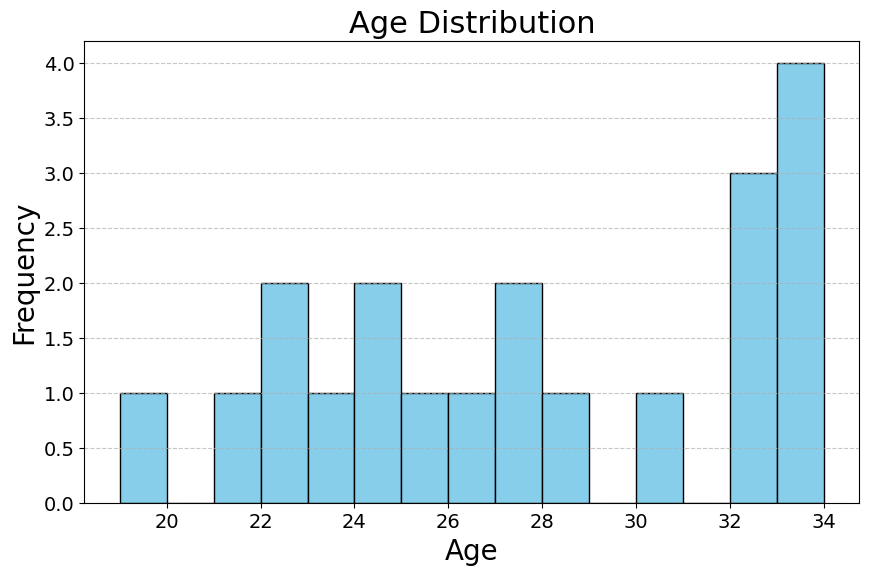

In [83]:
# get demographic data and plot it
demographic_data = df_completed[['id', 'age', 'gender', 'country', 'language', 'tinnitus', 'hearing_loss', 'headphone_style']]
demographic_data = demographic_data.drop_duplicates(subset=['id'])
demographic_data = demographic_data.reset_index(drop=True)

demographic_data

# Count the number of women and men
gender_counts = demographic_data['gender'].value_counts()
print("Gender distribution:")
print(gender_counts)

# List unique countries
unique_countries = demographic_data['country'].unique()
print("\nCountries:")
print(unique_countries)
country_counts = demographic_data['country'].value_counts()
print("Country distribution:")
print(country_counts)


# Count headphone styles
headphone_style_counts = demographic_data['headphone_style'].value_counts()
print("\nHeadphone styles:")
print(headphone_style_counts)

# Plot age distribution
plt.figure(figsize=(10, 6))
demographic_data['age'] = pd.to_numeric(demographic_data['age'], errors='coerce')  # Convert age to numeric
demographic_data['age'].dropna().plot(kind='hist', bins=15, color='skyblue', edgecolor='black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [70]:
# group by "id" and find the lowest and the highest score for each id
df_participants = df_completed.copy()
df_participants = df_participants[['id', 'trial_type',  'rating']]
df_participants = df_participants.groupby(['id', 'trial_type']).agg(['min', 'max'])
df_participants;



    trial_type stimulus rating
0           ps     pvps      0
594         ps     pvps     13
596         ps   anchor     25
597         ps     nmps     33
598         ps   anchor     41
..         ...      ...    ...
305        tsm       nm     20
306        tsm       pv     35
307        tsm   tsmnet     14
308        tsm      hps     25
903        tsm   tsmnet     15

[900 rows x 3 columns]


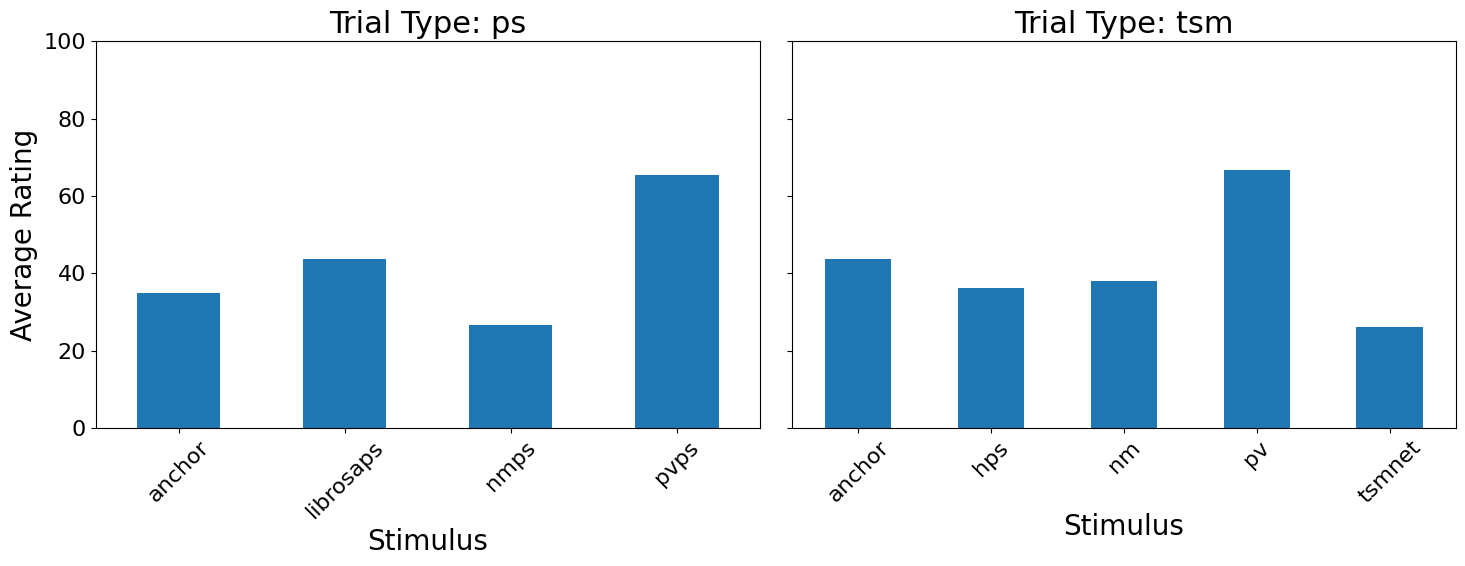

In [71]:
df_ratings = df_completed.copy()
df_ratings = df_ratings[['trial_type', 'stimulus', 'rating']]
print(df_ratings)

# group by trial_type and stimulus and plot the ratings
df_ratings_grouped = df_ratings.groupby(['trial_type', 'stimulus']).mean().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=len(df_ratings_grouped['trial_type'].unique()), figsize=(15, 6), sharey=True)

for ax, trial_type in zip(axes, df_ratings_grouped['trial_type'].unique()):
    df_subset = df_ratings_grouped[df_ratings_grouped['trial_type'] == trial_type]
    df_subset.plot(kind='bar', x='stimulus', y='rating', ax=ax, legend=False)
    ax.set_title(f'Trial Type: {trial_type}')
    ax.set_xlabel('Stimulus')
    ax.set_ylabel('Average Rating')
    ax.set_xticklabels(df_subset['stimulus'], rotation=45)
    ax.set_ylim(0, 100)

fig.tight_layout()
plt.show()

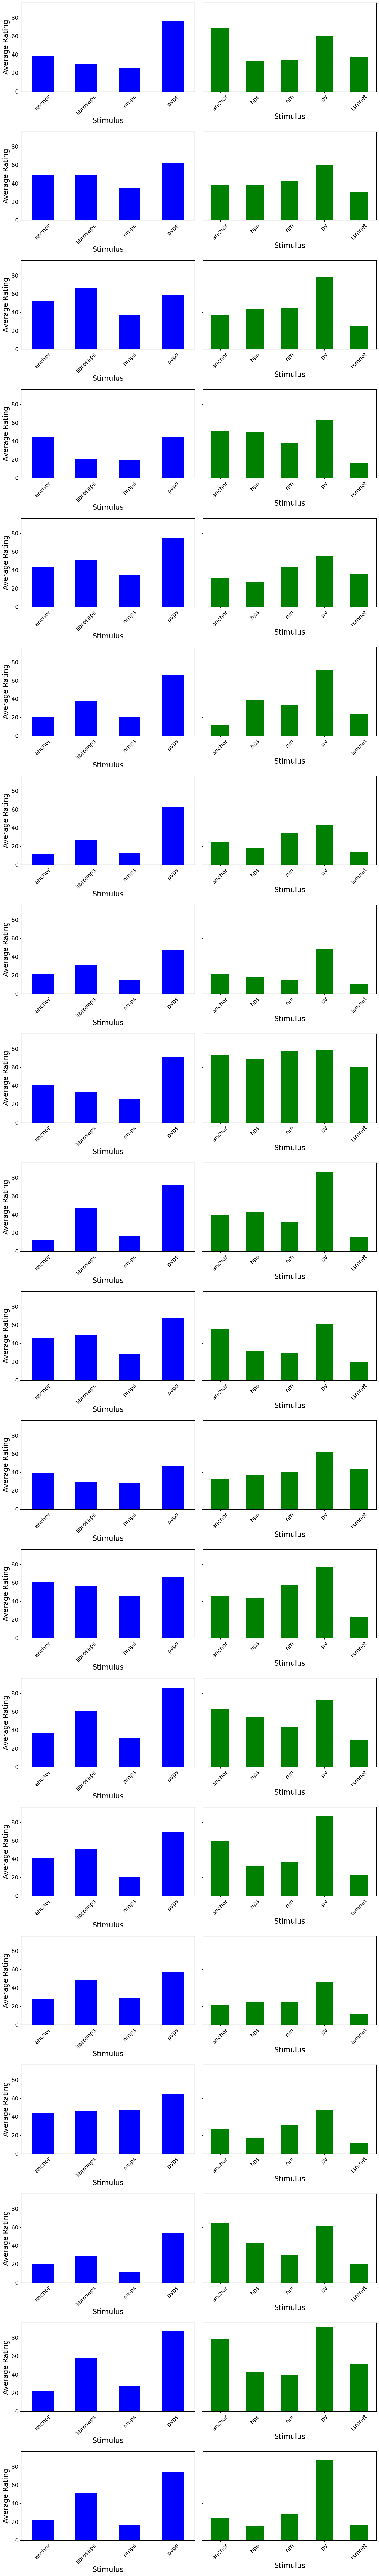

In [72]:
df_ratings = df_completed.copy()
df_ratings = df_ratings[['id', 'trial_type', 'stimulus', 'rating']]
df_ratings = df_ratings.sort_values(by=['stimulus'])
# Get unique participants
unique_participants = df_ratings['id'].unique()

# Create subplots with one row per participant and two columns (one for ps, one for tsm)
fig, axes = plt.subplots(nrows=len(unique_participants), ncols=2, figsize=(15, 5 * len(unique_participants)), sharey=True)

for ax_row, participant_id in zip(axes, unique_participants):
    # Filter data for the current participant
    participant_data = df_ratings[df_ratings['id'] == participant_id]
    
    # Plot ps ratings
    ps_data = participant_data[participant_data['trial_type'] == 'ps']
    if not ps_data.empty:
        ps_data.groupby('stimulus')['rating'].mean().plot(kind='bar', ax=ax_row[0], color='blue', legend=False)
        ax_row[0].set_xlabel('Stimulus')
        ax_row[0].set_ylabel('Average Rating')
        ax_row[0].set_xticklabels(ps_data['stimulus'].unique(), rotation=45)
    else:
        ax_row[0].set_visible(False)

    # Plot tsm ratings
    tsm_data = participant_data[participant_data['trial_type'] == 'tsm']
    if not tsm_data.empty:
        tsm_data.groupby('stimulus')['rating'].mean().plot(kind='bar', ax=ax_row[1], color='green', legend=False)
        ax_row[1].set_xlabel('Stimulus')
        ax_row[1].set_ylabel('Average Rating')
        ax_row[1].set_xticklabels(tsm_data['stimulus'].unique(), rotation=45)
    else:
        ax_row[1].set_visible(False)

fig.tight_layout()
plt.show()

In [73]:
# map rating score from 0-100 to 1-5 MOS scale
df_mos_scaled = df_completed.copy()
df_mos_scaled['rating'] = df_mos_scaled['rating'].map(lambda x: (x/100)*4+1)
df_mos_scaled;

In [74]:
df_short = df_mos_scaled[['trial_type', 'factor', 'stimulus', 'rating']]
df_grouped = df_short.groupby(['trial_type', 'factor', 'stimulus']).agg(['mean', 'std'])
df_grouped

rating          
                              mean       std
trial_type factor stimulus                  
ps         -7.00  anchor     2.022  0.809988
                  librosaps  1.736  0.605435
                  nmps       1.536  0.765619
                  pvps       2.130  1.015242
           -1.00  anchor     3.122  0.894754
                  librosaps  2.860  0.988481
                  nmps       2.336  0.688357
                  pvps       4.114  0.833537
            1.00  anchor     3.248  0.919093
                  librosaps  3.276  0.732626
                  nmps       2.614  0.765495
                  pvps       4.452  0.743941
            3.00  anchor     1.826  0.486842
                  librosaps  3.126  0.912996
                  nmps       2.086  0.765385
                  pvps       4.098  0.719236
            7.00  anchor     1.738  0.720406
                  librosaps  2.762  0.761436
                  nmps       1.732  0.660730
                  pvps       3.292  1.153930
tsm         0.75  anchor     2.792  1.047632
                  hps        2.852  0.969089
                  nm         2.382  0.703013
                  pv         3.826  0.715692
                  tsmnet     1.810  0.837327
            0.85  anchor     3.740  0.866451
                  hps        2.298  0.835474
                  nm         2.988  0.676972
                  pv         4.202  0.670268
                  tsmnet     2.500  1.047383
            1.25  anchor     2.676  1.188783
                  hps        2.838  0.970077
                  nm         2.506  0.835857
                  pv         3.826  1.060151
                  tsmnet     1.774  0.724811
            1.35  anchor     2.434  1.094774
                  hps        2.234  0.610956
                  nm         2.650  0.729167
                  pv         3.688  0.822074
                  tsmnet     2.346  0.782253
            1.50  anchor     2.080  1.085949
                  hps        2.000  0.437986
                  nm         2.054  0.867400
                  pv         2.818  1.042303
                  tsmnet     1.766  0.480925

In [75]:
# analysis_test = df_mos_scaled[['trial_type', 'stimulus', 'rating']].groupby(['trial_type', 'stimulus']).agg(['mean'])
# analysis_test.to_csv('evaluation/subjective/analysis_test.csv')


### Cliff's Delta, Wilcoxon and other tests

In [76]:
from scipy.stats import norm

# calculate confidence intervals
confidence_level = 0.95
z_score = norm.ppf(1 - (1 - confidence_level) / 2)

df_grouped['rating', 'ci'] = z_score * (df_grouped['rating', 'std'] / np.sqrt(df_grouped['rating', 'std'].count()))

df_grouped;

In [77]:
df_ps = df_short[df_short['trial_type'] == 'ps']
df_ps.loc[df_ps['stimulus'] == 'anchor', 'stimulus'] = 'psola'
df_ps


,trial_type,factor,stimulus,rating
0,ps,7.0,pvps,1.00
594,ps,-7.0,pvps,1.52
596,ps,-7.0,psola,2.00
597,ps,-1.0,nmps,2.32
598,ps,-1.0,psola,2.64
...,...,...,...,...
286,ps,1.0,librosaps,3.20
287,ps,7.0,pvps,2.60
288,ps,7.0,psola,1.72
289,ps,7.0,librosaps,2.80


In [78]:
df_tsm = df_short[df_short['trial_type'] == 'tsm']
df_tsm.loc[df_tsm['stimulus'] == 'anchor', 'stimulus'] = 'res'
df_tsm

,trial_type,factor,stimulus,rating
609,tsm,1.50,tsmnet,2.20
610,tsm,1.50,pv,3.40
611,tsm,1.50,res,1.08
612,tsm,1.50,hps,1.88
613,tsm,1.50,nm,1.52
...,...,...,...,...
305,tsm,1.25,nm,1.80
306,tsm,1.50,pv,2.40
307,tsm,1.50,tsmnet,1.56
308,tsm,1.50,hps,2.00


In [79]:
from scipy.stats import wilcoxon


def run_wilcoxon_test(dataframe, stimulus_test):
    # Get unique stimuli excluding 'stimulus_test'
    unique_stimuli = dataframe['stimulus'].unique()
    unique_stimuli = unique_stimuli[unique_stimuli != stimulus_test]
    ps_scores = dataframe[dataframe['stimulus'] == stimulus_test]['rating']

    # Perform the Wilcoxon signed-rank test for 'stimulus_test' against each unique stimulus
    results = {}
    for stimulus in unique_stimuli:
        stimulus_scores = dataframe[dataframe['stimulus'] == stimulus]['rating']
        stat, p_value = wilcoxon(ps_scores, stimulus_scores)
        results[stimulus] = {'stat': stat, 'p_value': p_value}

    # Print the results
    for stimulus, result in results.items():
        print(f'Wilcoxon signed-rank test pairing {stimulus_test} with {stimulus}:')
        print(f'  Statistic: {result["stat"]}')
        print(f'  p-value: {result["p_value"]}\n')
        
    return results

tsm_wilcoxon_results = run_wilcoxon_test(df_tsm, 'pv')
ps_wilcoxon_results = run_wilcoxon_test(df_ps, 'pvps')

Wilcoxon signed-rank test pairing pv with tsmnet:
  Statistic: 102.5
  p-value: 1.2213612198555263e-16

Wilcoxon signed-rank test pairing pv with res:
  Statistic: 670.5
  p-value: 4.99689233197861e-10

Wilcoxon signed-rank test pairing pv with hps:
  Statistic: 294.0
  p-value: 1.7064668491914208e-14

Wilcoxon signed-rank test pairing pv with nm:
  Statistic: 352.0
  p-value: 3.2220012770431126e-13

Wilcoxon signed-rank test pairing pvps with psola:
  Statistic: 620.5
  p-value: 9.616461875676655e-11

Wilcoxon signed-rank test pairing pvps with nmps:
  Statistic: 356.5
  p-value: 1.4214617280039889e-13

Wilcoxon signed-rank test pairing pvps with librosaps:
  Statistic: 1005.5
  p-value: 2.9111566709707403e-07



In [80]:
from cliffs_delta import cliffs_delta

def run_cliffs_delta(dataframe, stimulus_test):
    # Get unique stimuli excluding 'stimulus_test'
    unique_stimuli = dataframe['stimulus'].unique()
    unique_stimuli = unique_stimuli[unique_stimuli != stimulus_test]

    # Perform the Cliff's Delta test for 'stimulus_test' against each unique stimulus
    results = {}
    for stimulus in unique_stimuli:
        stimulus_scores = dataframe[dataframe['stimulus'] == stimulus]['rating']
        stimulus_test_scores = dataframe[dataframe['stimulus'] == stimulus_test]['rating']
        d, res = cliffs_delta(stimulus_scores, stimulus_test_scores)
        results[stimulus] = {'delta': np.abs(d), 'magnitude': res}

    # Print the results
    for stimulus, result in results.items():
        print(f"Cliff's Delta test pairing {stimulus_test} with {stimulus}:")
        print(f"  Delta: {result['delta']}")
        print(f"  Magnitude: {result['magnitude']}\n")
        
    return results

tsm_cliffs_delta_results = run_cliffs_delta(df_tsm, 'pv')
ps_cliffs_delta_results = run_cliffs_delta(df_ps, 'pvps')

Cliff's Delta test pairing pv with tsmnet:
  Delta: 0.7707
  Magnitude: large

Cliff's Delta test pairing pv with res:
  Delta: 0.446
  Magnitude: medium

Cliff's Delta test pairing pv with hps:
  Delta: 0.6408
  Magnitude: large

Cliff's Delta test pairing pv with nm:
  Delta: 0.6222
  Magnitude: large

Cliff's Delta test pairing pvps with psola:
  Delta: 0.5592
  Magnitude: large

Cliff's Delta test pairing pvps with nmps:
  Delta: 0.6637
  Magnitude: large

Cliff's Delta test pairing pvps with librosaps:
  Delta: 0.4401
  Magnitude: medium



In [81]:
from effect_size_analysis.cliff_delta import cliff_delta

# cliff_delta(s1=x,s2=y,alpha=0.05,accurate_ci=True)
def run_cliffs_delta_analysis(dataframe, stimulus_test):
    # Get unique stimuli excluding 'PS'
    unique_stimuli = dataframe['stimulus'].unique()
    unique_stimuli = unique_stimuli[unique_stimuli != stimulus_test]

    # Perform the Cliff's Delta test for 'PS' against each unique stimulus
    results = {}
    for stimulus in unique_stimuli:
        stimulus_scores = dataframe[dataframe['stimulus'] == stimulus]['rating']
        stimulus_test_scores = dataframe[dataframe['stimulus'] == stimulus_test]['rating']
        d, res = cliff_delta(s2=stimulus_test_scores, s1=stimulus_scores, alpha=0.05, accurate_ci=True)
        results[stimulus] = {'delta': np.abs(d), 'magnitude': np.sort(np.abs(res))}

    # Print the results
    for stimulus, result in results.items():
        print(f"Cliff's δ Effect Size test pairing {stimulus_test} with {stimulus}:")
        print(f"  Delta: {result['delta']}")
        print(f"  Confidende Interval: {result['magnitude']}\n")
        
    return results

tsm_cliffs_delta_analysis_results = run_cliffs_delta_analysis(df_tsm, 'pv')
ps_cliffs_delta_analysis_results = run_cliffs_delta_analysis(df_ps, 'pvps')

Cliff's δ Effect Size test pairing pv with tsmnet:
  Delta: 0.7707
  Confidende Interval: [0.66347505 0.84690477]

Cliff's δ Effect Size test pairing pv with res:
  Delta: 0.446
  Confidende Interval: [0.29832513 0.57282109]

Cliff's δ Effect Size test pairing pv with hps:
  Delta: 0.6408
  Confidende Interval: [0.50987977 0.74270829]

Cliff's δ Effect Size test pairing pv with nm:
  Delta: 0.6222
  Confidende Interval: [0.48799464 0.72766606]

Cliff's δ Effect Size test pairing pvps with psola:
  Delta: 0.5592
  Confidende Interval: [0.41735741 0.674443  ]

Cliff's δ Effect Size test pairing pvps with nmps:
  Delta: 0.6637
  Confidende Interval: [0.53221788 0.76391986]

Cliff's δ Effect Size test pairing pvps with librosaps:
  Delta: 0.4401
  Confidende Interval: [0.28275043 0.57438382]



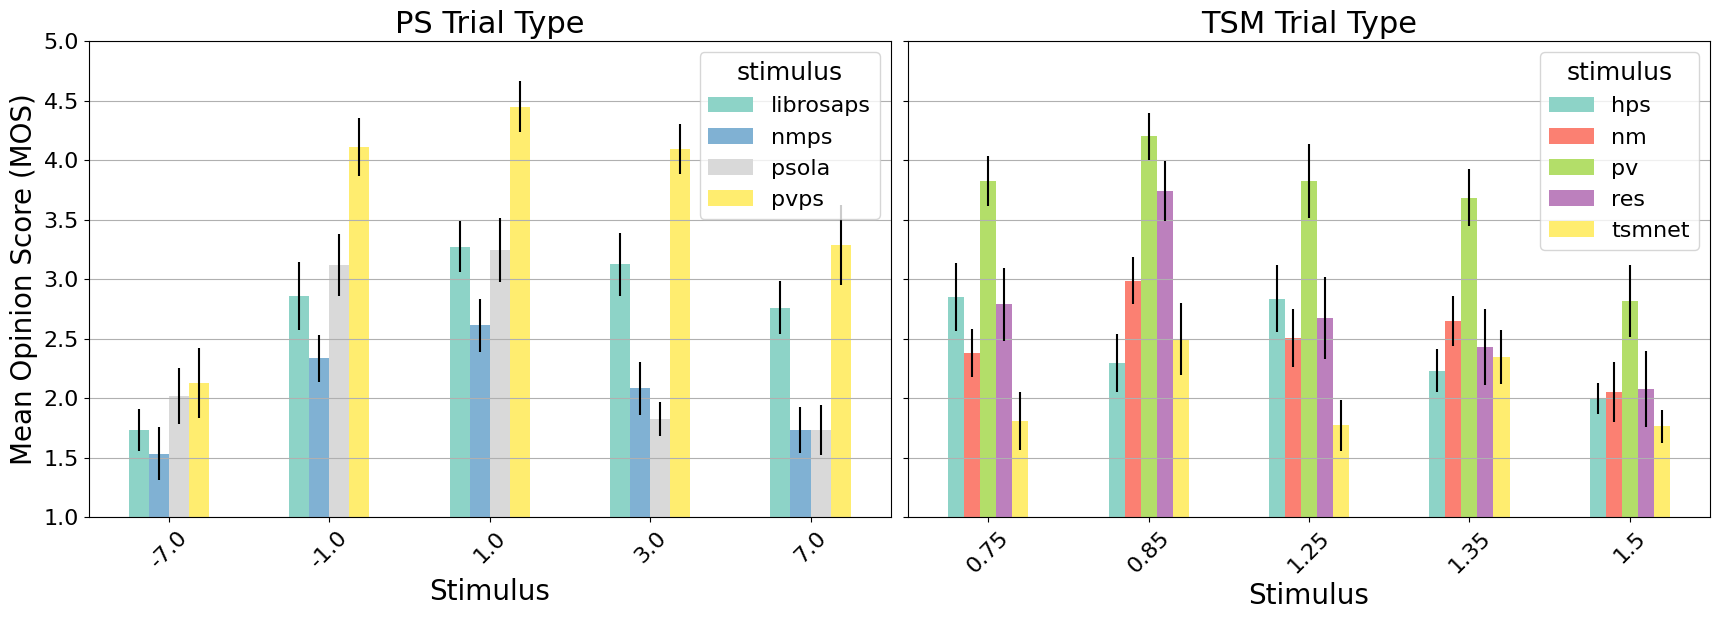

In [84]:
# Separate data by trial_type
df_ps = df_grouped.xs('ps', level='trial_type').copy()
df_ps.reset_index(inplace=True)
df_ps.loc[df_ps['stimulus'] == 'anchor', 'stimulus'] = 'psola'
df_ps.set_index(['factor', 'stimulus'], inplace=True)
df_tsm = df_grouped.xs('tsm', level='trial_type')
df_tsm.reset_index(inplace=True)
df_tsm.loc[df_tsm['stimulus'] == 'anchor', 'stimulus'] = 'res'
df_tsm.set_index(['factor', 'stimulus'], inplace=True)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7), sharey=True)

# Plot for 'ps'
df_ps['rating'].unstack().plot(kind='bar', y='mean', yerr='ci', ax=axes[0], colormap='Set3')
axes[0].yaxis.grid(True)
axes[0].set_title('PS Trial Type')
axes[0].set_xlabel('Stimulus')
axes[0].set_ylabel('Mean Opinion Score (MOS)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_ylim(1, 5)

# Plot for 'tsm'
df_tsm['rating'].unstack().plot(kind='bar', y='mean', yerr='ci', ax=axes[1], colormap='Set3')
axes[1].yaxis.grid(True)
axes[1].set_title('TSM Trial Type')
axes[1].set_xlabel('Stimulus')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_ylim(1, 5)

fig.tight_layout(pad=2.0, w_pad=0.5)
plt.show()